# Image_Classification_Pytorch (Training)
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

<a class="anchor" id="0"></a>
# Table of Contents

1. [套件安裝與載入](#1)
1. [環境檢測與設定](#2)
1. [開發參數設定](#3)
1. [資料處理](#4)
    -  [載入CSV檔](#4.1)
    -  [檢查CSV檔缺失值](#4.2)
1. [定義模型方法](#5)
1. [定義回調函數方法](#6)
1. [製作資料集＆資料擴增&回調函數&訓練模型](#7)
1. [混淆矩陣 & Quadratic Weighted Kappa](#8)
1. [待辦事項](#9)

# 1. 套件安裝與載入<a class="anchor" id="1"></a>
[Back to Table of Contents](#0)

In [1]:
!pip3 install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-yl0pkchq
  Running command git clone -q https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-yl0pkchq
  Created wheel for timm: filename=timm-0.4.8-py3-none-any.whl size=338238 sha256=273257032a6ddab3f5467ac5f882af9d7ec1255f3ad8b072f9e494a02892cbf8
  Stored in directory: /tmp/pip-ephem-wheel-cache-6s9pttfi/wheels/a0/ec/5f/289118b747739bb1e02e36cf3d7e759721e881c183653719dc
Successfully built timm


In [2]:
# 資料處理套件
import os
import cv2
import sys
import time
import timm
import copy
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt

from tqdm import tqdm
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score, classification_report, cohen_kappa_score)

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 設定顯示中文字體
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 用來正常顯示中文標籤
plt.rcParams['font.family'] = 'AR PL UMing CN'
plt.rcParams['axes.unicode_minus'] = False # 用來正常顯示負號

In [4]:
# pytorch深度學習模組套件
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision

from torch.optim import lr_scheduler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import models

# 2. 環境檢測與設定<a class="anchor" id="2"></a>
[Back to Table of Contents](#0)

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [6]:
'''執行環境參數設定'''

# (Boolean)是否為本機
LOCAL = False

# (Boolean)是否為 Colab
COLAB = False


'''檔案路徑參數設定'''

# (String)Root路徑
if LOCAL:
    PATH = r'../'
elif COLAB:
    PATH = r'/content/drive/My Drive/Colab Notebooks/'
else:
    PATH = r'../input/'
    OUTPUT_PATH = r'/kaggle/working/'
    
# (String)資料根路徑
DATA_ROOT_PATH = PATH+r'aptos2019-blindness-detection/' 

# (String)訓練資料路徑
TRAIN_DATA_PATH = DATA_ROOT_PATH+r'train_images/'

# (String)訓練CSV路徑，如為None則不讀CSV檔
TRAIN_CSV_PATH = DATA_ROOT_PATH+r'train.csv'

# (String)專案名稱
PROJECT_NAME = 'Blindness Detection'

# (String)專案檔案儲存路徑
if LOCAL or COLAB:
    OUTPUT_PATH = PATH
PROJECT_PATH = OUTPUT_PATH+PROJECT_NAME+'/'+PROJECT_NAME+' '+datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

# (String)權重名稱(使用哪個權重)
WEIGHTS_NAME = 'resnet18'

# (String)模型名稱(使用哪個模型)
MODEL_NAME = 'resnet18'

# (String)讀取預訓練權重的儲存路徑 
LOAD_WEIGHTS_PATH = PROJECT_PATH+r'/models/backup/'+WEIGHTS_NAME+'.pth'

# (String)讀取預訓練模型的儲存路徑 
LOAD_MODEL_PATH = PROJECT_PATH+r'/models/backup/'+MODEL_NAME+'.pth'

# (String)訓練模型的儲存路徑
TRAIN_MODEL_PATH = PROJECT_PATH+r'/models/'+MODEL_NAME+'.pth'

In [7]:
if not LOCAL and COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [8]:
if DEVICE != "CPU":
    !nvidia-smi

/bin/bash: nvidia-smi: command not found


In [9]:
if os.path.isfile(TRAIN_CSV_PATH):
    LOAD_CSV = True
else:
    LOAD_CSV = False

In [10]:
if not os.path.isdir(PROJECT_PATH+r'/models/'):
    os.makedirs(PROJECT_PATH+r'/models/')

# 3. 開發參數設定<a class="anchor" id="3"></a>
[Back to Table of Contents](#0)

In [11]:
'''客製參數設定'''


'''資料參數設定'''

# (Int)分類數量
CLASSES = 5

# (Int)有CSV檔該參數才有用，1則為不做交叉驗證
FOLD = 1
    
# (Int)圖片尺寸
IMAGE_SIZE = [224]*FOLD

# (String)圖片副檔名
IMAGE_NAME_EXTENSION = '.png'

# (String)CSV圖片檔名欄位
IMAGE_NAME = 'id_code'

# (String)CSV標籤欄位
LABEL_NAME = 'diagnosis'

# (String)CSV標籤欄位類型
LABEL_NAME_TYPE = 'string'

# (Boolean)CSV圖片檔名欄位是否包含副檔名
IMAGE_NAME_HAVE_EXTENSION = False

# (Boolean)是否轉DataSet時，讓標籤做獨熱編碼
ONE_HOT_LABEL = False

#  (Boolean)圖像轉為RGB
COLOR_CONVERT_RGB = True

# (Int)不同的種子會產生不同的Random或分層K-FOLD分裂, 42則是預設固定種子
SEED = 42

if FOLD == 1:
    # (Float)驗證集佔訓練集的比率，FOLD>1則不啟用
    DATA_SPLIT = 0.2
else:
    # (String)切分訓練集跟驗證集方式
    SKF = StratifiedKFold(n_splits=FOLD,shuffle=True,random_state=SEED)

# (Boolean)是否資料轉Tensor時啟動鎖頁內存(GPU內存)，而不鎖頁內存就是會使用到硬碟虛擬內存
PIN_MEMORY = False

# (Int)要用於數據加載的子進程數。0表示將在主進程中加載數據。（默認值：0）
NUM_WORKERS = 0

# (Boolean)批次處理在大小不合適的情況下，是否刪除最後一個不完整的批次
DROP_LAST = False
    
# (Boolean)如為True每次返回的卷積算法將是確定的，即默認算法
CUDNN_DETERMINISTIC = True

# (Boolean)PyTorch 中對模型裡的卷積層進行預先的優化，也就是在每一個卷積層中測試 cuDNN 提供的所有卷積實現算法，
# 然後選擇最快的那個。這樣在模型啟動的時候，只要額外多花一點點預處理時間，就可以較大幅度地減少訓練時間
CUDNN_BENCHMARK = True


'''資料擴增參數設定

資料擴增範例
https://zh-hant.hotbak.net/key/albumentation%E6%95%B8%E6%93%9A%E5%A2%9E%E5%BC%B7CSDN.html

資料擴增教學
https://zhuanlan.zhihu.com/p/107399127

資料擴增Doc
https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/api/augmentations.html
'''

# (Float)訓練集資料擴增的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_TRAIN_TRANSFORMS = 1.0

# (Float)驗證集資料擴增的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_VAL_TRANSFORMS = 1.0

# 以下資料擴增為訓練集使用=============================================

# (Float)模糊的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_BLUR = 0

# (Int)模糊的上限
BLUR_LIMIT = 3

# (Float)水平翻轉的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_HORIZONTALFLIP = 0

# (Float)垂直翻轉的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_VERTICALFLIP = 0

# (Float)水平和垂直翻轉的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_FLIP = 0

# (Float)隨機旋轉90度的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_RANDOMROTATE90 = 0

# (Float)平移縮放旋轉的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_SHIFTSCALEROTATE = 0

# (Float)平移縮放旋轉的平移上限
SHIFTSCALEROTATE_SHIFT_LIMIT = 0.0625

# (Float)平移縮放旋轉的縮放上限
SHIFTSCALEROTATE_SCALE_LIMIT = 0.1

# (Float)平移縮放旋轉的旋轉上限
SHIFTSCALEROTATE_ROTATE_LIMIT = 45

# (Float)彈性變換的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_ELATICTRANSFORM = 0

# (Float)彈性變換的alpha高斯過濾參數
ELATICTRANSFORM_ALPHA = 1

# (Float)彈性變換的sigma高斯過濾參數
ELATICTRANSFORM_SIGMA = 50

# (Float)彈性變換的alpha_affine，範圍為（-alpha_affine，alpha_affine）
ELATICTRANSFORM_ALPHA_AFFINE = 50

# (Float)網格失真的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_GRIDDISTORTION = 0

# (Int)網格失真的每一條邊上網格單元數量
GRIDDISTORTION_NUM_STEPS = 5

# (Float)隨機亮度對比度的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_RANDOMBRIGHTNESSCONTRAST_CONTRAST = 0

# (Float)隨機亮度的上限
RANDOMBRIGHTNESSCONTRAST_BRIGHTNESS_LIMIT = 0.2

# (Float)隨機對比度的上限
RANDOMBRIGHTNESSCONTRAST_CONTRAST_LIMIT = 0.2

# (Float)隨機色調飽和度的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_HUESATURATIONVALUE = 0

# (Float)隨機色調飽和度的色調上限
HUESATURATIONVALUE_HUE_SHIFT_LIMIT = 20

# (Float)隨機色調飽和度的飽和度上限
HUESATURATIONVALUE_SAT_SHIFT_LIMIT = 30

# (Float)隨機色調飽和度的值上限
HUESATURATIONVALUE_VAL_SHIFT_LIMIT = 20

# (Float)對比度受限自適應直方圖均衡的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_CLAHE = 0

# (Float)對比度受限自適應直方圖均衡的對比度上限
CLAHE_CLIP_LIMIT = 4.0

# (Float)隨機在圖像上生成黑色矩形的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_COARSEDROPOUT = 0

# (Int)隨機在圖像上生成黑色矩形的數量
COARSEDROPOUT_NUM_HOLES = 8

# (Int)隨機在圖像上生成黑色矩形的最大高度
COARSEDROPOUT_MAX_H_SIZE = 8

# (Int)隨機在圖像上生成黑色矩形的最大寬度
COARSEDROPOUT_MAX_W_SIZE = 8

# (Float)隨機縮放剪裁的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_RANDOMRESIZEDCROP = 0

# (Float Tuple)隨機縮放剪裁之前的圖像比例縮放
RANDOMRESIZEDCROP_SCALE = (0.08, 1.0)

# (Int)隨機縮放剪裁之前的圖像高度
RANDOMRESIZEDCROP_HEIGHT = IMAGE_SIZE[0]

# (Int)隨機縮放剪裁之前的圖像寬度
RANDOMRESIZEDCROP_WIDTH = IMAGE_SIZE[0]

# 以上資料擴增為訓練集使用=============================================

# 以下資料擴增為訓練集和驗證集共用======================================

# (Float)縮放的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_RESIZE = 1.0

# (Int)縮放後的圖片高度
RESIZE_HEIGHT = IMAGE_SIZE[0]

# (Int)縮放後的圖片寬度
RESIZE_WIDTH = IMAGE_SIZE[0]

# (Float)正規化的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
P_NORMALIZE = 1.0

# (List)正規化的平均值(Imagenet的參考平均值[0.485, 0.456, 0.406])
NORMALIZE_MEAN = [0.485, 0.456, 0.406]

# (List)正規化的標準差(Imagenet的參考標準差[0.229, 0.224, 0.225])
NORMALIZE_STD = [0.229, 0.224, 0.225]

# (Float)正規化的PIXEL最大值(Imagenet的參考PIXEL最大值255.0)
NORMALIZE_MAX_PIXEL_VALUE = 255.0

# (Float)歸一化的啟用(0:不啟用,1.0:一律啟用,小數點:機率啟用)
# ToTensorV2()將[0, 255]的PIL.Image或[H, W, C]的numpy.ndarray數據，
# 轉換為形狀[C, H, W]的torch.FloadTensor，並歸一化到[0, 1.0]。
P_TOTENSORV2 = 1.0

# 以上資料擴增為訓練集和驗證集共用======================================


''''模型參數設定'''

# (Boolean)使用基礎模型，如為False則須客制另外撰寫
USE_BASE_MODEL = True

if USE_BASE_MODEL:
    # (Boolean)使用基礎timm模型，如為False則使用基礎Pytorch模型
    USE_BASE_TIMM_MODEL = False
    if USE_BASE_TIMM_MODEL:
        # (Model)建立timm模型
        BASE_MODEL = "tf_efficientnet_b4_ns"
    else:
        # (Model)建立Pytorch模型
        BASE_MODEL = models.resnet18
    
# (Boolean)是否使用基礎模型權重
LOAD_BASE_WEIGHTS = True

# (Boolean)基礎模型是否包含完全連接網路頂部的網路層
INCLUDE_TOP = False

# (Boolean)基礎模型是否可訓練權重(不包括頂部網路層)
BASE_MODEL_TRAINABLE = False

# (Boolean)是否已有客製模型，僅載入權重
LOAD_WEIGHTS = False

# (Boolean)是否載入完整客製(模型+權重)
LOAD_MODEL = False

# (Float)Dropout比率 0.5
DROPOUT = 0.5

# (Boolean)Bias偏移量
BIAS = True

# (Boolean)是否印出完整模型
MODEL_PRINT = False


''''回調函數參數設定

學習率遞減
https://zhuanlan.zhihu.com/p/69411064

回調函數Doc
https://pytorch.org/docs/stable/optim.html

模型儲存
https://pytorch.org/tutorials/beginner/saving_loading_models.html

'''

# (Boolean)回調函數 ModelCheckpoint 是否啟用
CALLBACKS_CHECK_POINTER = True

# (Boolean)回調函數 EarlyStopping 是否啟用
CALLBACKS_EARLY_STOPPING = False

# (Boolean)回調函數 StepLR 是否啟用
CALLBACKS_STEPLR = True

# (Boolean)回調函數 ReduceLROnPlateau 是否啟用
CALLBACKS_REDUCELRONPLATEAU = False

# (Boolean)回調函數 CosineAnnealingWarmRestarts 是否啟用
CALLBACKS_COSINEANNEALINGWARMRESTAERS = False

# (String)回調函數監控數值(val_auc 僅限雙分類) val_acc/val_loss/val_auc
MONITOR = 'val_loss'

# (Boolean)回調函數 ModelCheckpoint 是否只儲存最佳模型 False
SAVE_BEST_ONLY = True

# (Boolean)回調函數 ModelCheckpoint 是否只儲存權重 True
SAVE_WEIGHTS_ONLY = True

# (Int)回調函數 EarlyStopping 沒有改善的時期數，之後訓練將停止 10
PATIENCE_ELS = 10

# (Int)學習率衰減的時間段
STEP_SIZE = 15

# (Float)學習率衰減的乘數 0.1
GAMMA = 0.1

# (String)最小，最大之一 在最小模式下，當監視的數量停止減少時，lr將減小； 在最大模式下，當監視的數量停止增加時，它將減少。 min
MODE = "min"

# (Float)學習率降低的因數。new_lr = lr *因子 0.1
FACTOR = 0.1

# (Int)沒有改善的時期數，此後學習率將降低。例如，如果 耐心= 2，那麼我們將忽略前兩個時期而沒有任何改善，
# 並且如果損失仍然沒有改善，則只會在第三個時期之後降低LR。 10
PATIENCE = 10 

# (Float)用於測量新的最佳閾值，僅關注重大變化。 1e-4
THRESHOLD = 1e-4 

# (String)rel，abs之一。在rel模式下，“ max”模式下的dynamic_threshold = best *（1 +閾值），在min模式下，
# dynamic_threshold = best *（1-threshold）。在絕對模式下，dynamic_threshold =最佳+ 最大模式下的閾值或最佳-最小模式下的閾值。 rel
THRESHOLD_MODE = "rel"

# (Int)減少lr後恢復正常運行之前要等待的時期數。 0 
COOLDOWN = 0

# (Float/List)標量或標量列表。所有參數組或每個組的學習率的下限。 0 
MIN_LR = 0

# (Float)應用於lr的最小衰減。如果新舊lr之間的差異小於eps，則忽略該更新。 1e-8
SCHEDULER_EPS = 1e-8

# (Int)第一次重啟的迭代次數。
T_0 = 15

# (Int)重新啟動後，因素增加。 1 
T_MULT = 1

# (Int)最低學習率。 0
ETA_MIN = 0

# (Boolean)每次更新，學習率回調函式都會向輸出印出一條消息。 False
SCHEDULER_VERBOSE = False

# (Boolean)訓練集每批就更新學習率回調函式，否則每時代就更新。 False
SCHEDULER_BATCH_UPDATE = False

# (Boolean)驗證集學習率回調函式是否啟用。 False
VAL_ENABLE_SCHEDULER = False

# (Boolean)驗證集通過計算LOSS就更新學習率回調函式，否則不計算就更新。 False
SCHEDULER_LOSS_UPDATE = False


''''編譯參數設定

編譯參數Doc
https://pytorch.org/docs/stable/optim.html

'''

# (String)優化器指定(SGD/Adam/Adamax/RMSprop/Adagrad)，None為客制，須另外撰寫
OPTIMIZERS_TYPE = "Adam"

# (Float)優化器學習率 1e-3/1e-1
LEARNING_RATE = 1e-3

# (Float)學習速率衰減 0
LR_DECAY = 0

# (Float)優化器權重衰減 5e-5/5e-4
WEIGHT_DECAY = 5e-5

# (Float)加速優化器在相關方向上前進，並抑制震盪 0.9
MOMENTUM = None

# (Tuple Float)用於計算梯度及其平方的移動平均值的係數 (0.9, 0.999)
BETAS = (0.9, 0.999)

# (Float)分母中添加的項，以提高數值穩定性 1e-8
EPS = 1e-8

# (Float)平滑常數 0.99
ALPHA = 0.99

# (Boolean)計算居中RMSProp，則通過估計其方差來對梯度進行歸一化 True
CENTERED = True

# (Float)阻尼動量 0
DAMPENING = 0

# (Boolean)啟用Nesterov動量 False
NESTEROV = False

# (String)損失函數，None為客制，須另外撰寫
BASE_LOSSES = nn.CrossEntropyLoss

if BASE_LOSSES is None:
    # (Boolean)使用客制Focal loss損失函數
    USE_FOCAL_LOSSES = True
    if USE_FOCAL_LOSSES:
        # (Float)對第一類影響進行減弱(目標檢測任務中,第一類為背景類) 0.25
        # (Int List)分別對每一類施加不同的權重 [1,2,3,1,2]
        FOCAL_LOSSES_ALPHA = 0.25
        
        # Focal loss的Gamma參數
        FOCAL_LOSSES_GAMMA = 2

# (String)指定還原成適用於輸出，預設mean
REDUCTION = "mean"

# (String )評價指標的圖表顯示 accuracy/auc
PLOT_METRICS = 'accuracy'

# (Boolean)是否印出完整編譯器
OPTIMIZER_PRINT = False


''''訓練參數設定'''

# (Int List)每批訓練的尺寸
BATCH_SIZE = [512]*FOLD

# (Int)訓練做幾次時代
EPOCHS = [1]*FOLD

# (Int)指定列印進度條的位置（從0開始）
TQDM_POSITION = 0

# (Boolean)保留迭代結束時進度條的所有痕跡。如果是None，只會在position是0時離開
TQDM_LEAVE = True

# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/02/19/gradient-accumulation.html
# (Int)假設您要在一批中使用32張圖像，但是一旦超出8張，硬件就會崩潰
# 在這種情況下，您可以使用8張圖像的批次並每4批次更新一次權重，因此設置 4
ACCUM_ITER = 1

# (Boolean)是否計算每個Epoch Step指標
CALCULATE_EPOCH_STEP = True

# (Boolean)是否計算每個Epoch Average指標
CALCULATE_EPOCH_AVERAGE = True

# (Boolean)需先開啟計算，是:畫出Epoch Average指標計算，否:畫出Epoch Step指標計算
PLOT_EPOCH_AVERAGE = False

# (Boolean)需先開啟計算，是:Tensorboard每個Epoch Average指標計算，否:Tensorboard每個Epoch Step指標計算
TENSORBOARD_EPOCH_AVERAGE = False


''''圖表參數設定'''

# (Float)全部SNS圖表的字形縮放
ALL_SNS_FONT_SCALE = 1.0

# (Int)CSV缺失值圖表寬度
CSV_COUNTPLOT_FIGSIZE_W = 10

# (Int)CSV缺失值圖表高度
CSV_COUNTPLOT_FIGSIZE_H = 10

# (Int)CSV缺失值圖表標題字型大小
CSV_COUNTPLOT_TITLE_FONTSIZE = 20

# (Int)CSV缺失值圖表X軸標題字型大小
CSV_COUNTPLOT_XLABEL_FONTSIZE = 15

# (Int)CSV缺失值圖表Y軸標題字型大小
CSV_COUNTPLOT_YLABEL_FONTSIZE = 15

# (Int)訓練歷程圖表寬度
TRAINING_CURVES_FIGSIZE_W = 20

# (Int)訓練歷程圖表高度
TRAINING_CURVES_FIGSIZE_H = 10

# (Int)訓練歷程圖表SCATTER的標記點大小 
TRAINING_CURVES_SCATTER_SCALAR = 200

# (Float)訓練歷程圖表SCATTER的指標文字離標記點X距離係數
TRAINING_CURVES_SCATTER_METRICS_TEXT_XSCALAR = 0.03

# (Float)訓練歷程圖表SCATTER的指標文字標記點Y距離係數
TRAINING_CURVES_SCATTER_METRICS_TEXT_YSCALAR = 0.13

# (Float)訓練歷程圖表SCATTER的損失文字標記點X距離係數
TRAINING_CURVES_SCATTER_LOSS_TEXT_XSCALAR = 0.03

# (Float)訓練歷程圖表SCATTER的損失文字標記點Y距離係數
TRAINING_CURVES_SCATTER_LOSS_TEXT_YSCALAR = 0.05

# (Int)訓練歷程圖表SCATTER的文字大小
TRAINING_CURVES_SCATTER_TEXTSIZE = 15

# (Int)訓練歷程圖表X軸標題字型大小
TRAINING_CURVES_XLABEL_FONTSIZE = 15

# (Int)訓練歷程圖表Y軸標題字型大小
TRAINING_CURVES_YLABEL_FONTSIZE = 15

# (Int)訓練歷程圖表標題字型大小
TRAINING_CURVES_TITLE_FONTSIZE = 20

# (Float)訓練歷程圖表格線粗度
TRAINING_CURVES_GRID_ALPHA = 0

# (Int)混淆矩陣圖表寬度
CONFUSION_MATRIX_FIGSIZE_W = 10

# (Int)混淆矩陣圖表高度
CONFUSION_MATRIX_FIGSIZE_H = 10

# (Int)混淆矩陣圖表內容字型大小
CONFUSION_MATRIX_HEATMAP_FONTSIZE = 15

# (Int)混淆矩陣圖表標題字型大小
CONFUSION_MATRIX_TITLE_FONTSIZE = 20

# (Int)混淆矩陣圖表X軸標題字型大小
CONFUSION_MATRIX_XLABEL_FONTSIZE = 15

# (Int)混淆矩陣圖表Y軸標題字型大小
CONFUSION_MATRIX_YLABEL_FONTSIZE = 15

# (String)預設'binary'：僅在目標為二進制，兩分類時適用。
#'micro'：通過計算總的真陽性，假陰性和假陽性來全局計算指標，多分類時適用。
#'macro'：計算每個標籤的指標，並找到其未加權平均值。這沒有考慮標籤不平衡，多分類時適用。
AVERAGE = 'macro'

In [12]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = CUDNN_DETERMINISTIC
    torch.backends.cudnn.benchmark = CUDNN_BENCHMARK

seed_everything(SEED)

In [13]:
# 設置sns圖表縮放係數
sns.set(font_scale = ALL_SNS_FONT_SCALE)

# 4. 資料處理<a class="anchor" id="4"></a>
[Back to Table of Contents](#0)

## 4.1 載入CSV檔 <a class="anchor" id="4.1"></a>
[Back to Table of Contents](#0)

In [14]:
if LOAD_CSV:
    print('Reading data...')

    # 讀取訓練資料集CSV檔
    train_csv = pd.read_csv(TRAIN_CSV_PATH,encoding="utf8")

    print('Reading data completed')

Reading data...
Reading data completed


In [15]:
if LOAD_CSV:
    # 顯示訓練資料集CSV檔
    print(train_csv.head())

        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


In [16]:
if LOAD_CSV:
    print("Shape of train_data :", train_csv.shape)

Shape of train_data : (3662, 2)


## 4.2 檢查CSV檔缺失值 <a class="anchor" id="4.2"></a>
[Back to Table of Contents](#0)

In [17]:
# 缺失值比率
if LOAD_CSV:
    total = train_csv.isnull().sum().sort_values(ascending = False)
    percent = (train_csv.isnull().sum()/train_csv.isnull().count()*100).sort_values(ascending = False)
    missing_train_csv  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_train_csv.head())

           Total  Percent
id_code        0      0.0
diagnosis      0      0.0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


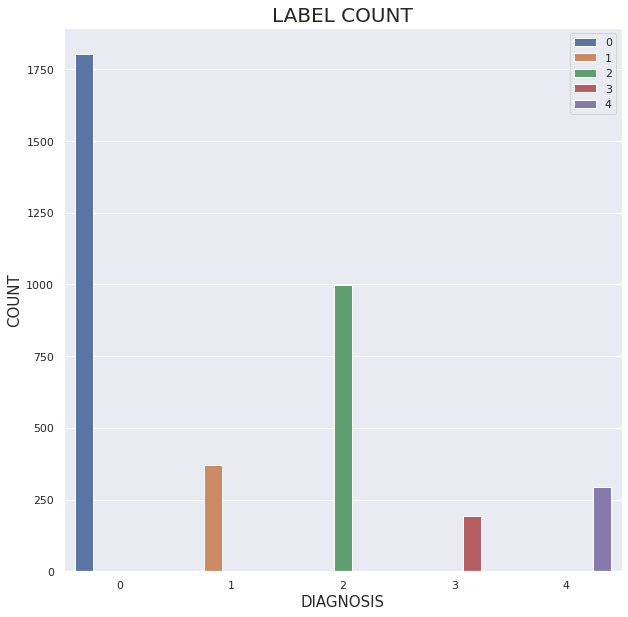

In [18]:
if LOAD_CSV:
    print(train_csv[LABEL_NAME].value_counts())
    f,ax = plt.subplots(figsize=(CSV_COUNTPLOT_FIGSIZE_W, CSV_COUNTPLOT_FIGSIZE_H))
    sns.countplot(train_csv[LABEL_NAME], hue = train_csv[LABEL_NAME],ax = ax)
    plt.title("LABEL COUNT", fontsize=CSV_COUNTPLOT_TITLE_FONTSIZE)
    plt.xlabel(LABEL_NAME.upper(), fontsize=CSV_COUNTPLOT_XLABEL_FONTSIZE)
    plt.ylabel("COUNT", fontsize=CSV_COUNTPLOT_YLABEL_FONTSIZE)
    plt.legend()
    plt.show()

# 5. 定義模型方法<a class="anchor" id="5"></a>
[Back to Table of Contents](#0)

In [19]:
def build_optimizers(model):
    if OPTIMIZERS_TYPE == None:
        print("Custiom OPTIMIZERS")
    elif OPTIMIZERS_TYPE == "SGD":
        RETURN_OPTIMIZERS = optim.SGD(model.parameters(), 
                                       lr = LEARNING_RATE, momentum = MOMENTUM, 
                                      dampening = DAMPENING, weight_decay = WEIGHT_DECAY, 
                                      nesterov = NESTEROV)
    elif OPTIMIZERS_TYPE == "Adam":
        RETURN_OPTIMIZERS = optim.Adam(model.parameters(), 
                                       lr = LEARNING_RATE, betas = BETAS, eps = EPS, 
                                       weight_decay = WEIGHT_DECAY)
    elif OPTIMIZERS_TYPE == "Adamax":
        RETURN_OPTIMIZERS = optim.Adamax(model.parameters(), 
                                         lr = LEARNING_RATE, betas = BETAS, eps = EPS, 
                                         weight_decay = WEIGHT_DECAY)
    elif OPTIMIZERS_TYPE == "RMSprop":
        RETURN_OPTIMIZERS = optim.RMSprop(model.parameters(), 
                                          lr = LEARNING_RATE, alpha = ALPHA, eps = EPS, 
                                          weight_decay = WEIGHT_DECAY, momentum = MOMENTUM, 
                                          centered = CENTERED)
    elif OPTIMIZERS_TYPE == "Adagrad":
        RETURN_OPTIMIZERS = optim.Adagrad(model.parameters(), 
                                          lr = LEARNING_RATE, lr_decay = LR_DECAY, 
                                          weight_decay = WEIGHT_DECAY)
    return RETURN_OPTIMIZERS

In [20]:
class focal_loss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, num_classes = 3, size_average=True):
        """
        focal_loss損失函數, -α(1-yi)**γ *ce_loss(xi,yi)
        步驟詳細的實現了 focal_loss損失函數.
        :param alpha: 阿爾法α,類別權重. 當α是列表時,為各類別權重,當α為常數時,類別權重為[α, 1-α, 1-α, ....],常用於目標檢測算法中抑制背景類, retainnet中設置為0.25
        :param gamma: 伽馬γ,難易樣本調節參數. retainnet中設置為2
        :param num_classes: 類別數量
        :param size_average: 損失計算方式,默認取均值
        """

        super(focal_loss,self).__init__()
        self.size_average = size_average
        if isinstance(alpha,list):
            assert len(alpha)==num_classes # α可以以list方式輸入,size:[num_classes] 用於對不同類別精細地賦予權重
            print("Focal_loss alpha = {}, 將對每一類權重進行精細化賦值".format(alpha))
            self.alpha = torch.Tensor(alpha)
        else:
            assert alpha<1 #如果α為一個常數,則降低第一類的影響,在目標檢測中為第一類
            print(" --- Focal_loss alpha = {} ,將對背景類進行衰減,請在目標檢測任務中使用 --- ".format(alpha))
            self.alpha = torch.zeros(num_classes)
            self.alpha[0] += alpha
            self.alpha[1:] += (1-alpha) # α 最終為 [ α, 1-α, 1-α, 1-α, 1-α, ...] size:[num_classes]
        self.gamma = gamma

    def forward(self, preds, labels):
        """
        focal_loss損失計算
        :param preds: 預測類別. size:[B,N,C] or [B,C] 分別對應與檢測與分類任務, B 批次, N檢測框數, C類別數
        :param labels: 實際類別. size:[B,N] or [B]
        :return:
        """
        # assert preds.dim()==2 and labels.dim()==1
        preds = preds.view(-1,preds.size(-1))
        self.alpha = self.alpha.to(preds.device)
        preds_softmax = F.softmax(preds, dim=1) # 這裡並沒有直接使用log_softmax, 因為後面會用到softmax的結果(當然你也可以使用log_softmax,然後進行exp操作)
        preds_logsoft = torch.log(preds_softmax)
        preds_softmax = preds_softmax.gather(1,labels.view(-1,1)) # 這部分實現nll_loss ( crossempty = log_softmax + nll )
        preds_logsoft = preds_logsoft.gather(1,labels.view(-1,1))
        self.alpha = self.alpha.gather(0,labels.view(-1))
        loss = -torch.mul(torch.pow((1-preds_softmax), self.gamma), preds_logsoft) # torch.pow((1-preds_softmax), self.gamma) 為focal loss中(1-pt)** γ
        loss = torch.mul(self.alpha, loss.t())
        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss

# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss
    
def build_losses():
    if BASE_LOSSES == None:
        if USE_FOCAL_LOSSES:
            RETURN_LOSSES = focal_loss(alpha = FOCAL_LOSSES_ALPHA, gamma = FOCAL_LOSSES_GAMMA, num_classes = CLASSES).to(DEVICE)
        else:
            RETURN_LOSSES = MyCrossEntropyLoss(reduction = REDUCTION).to(DEVICE)
        print("Custiom LOSSES")
    else:
        RETURN_LOSSES = BASE_LOSSES(reduction = REDUCTION).to(DEVICE)
    return RETURN_LOSSES

In [21]:
class build_default_model(nn.Module):

    def __init__(self):
        super().__init__()
        if USE_BASE_TIMM_MODEL:
            self.model = timm.create_model(BASE_MODEL, pretrained = LOAD_BASE_WEIGHTS)
        else:
            self.model = BASE_MODEL(pretrained = LOAD_BASE_WEIGHTS)

        if not BASE_MODEL_TRAINABLE:
            for param in self.model.parameters():
                param.requires_grad = False

        if INCLUDE_TOP:
            # Alternatively, it can be generalized to nn.Linear(num_ftrs, CLASSES)
            if USE_BASE_TIMM_MODEL:
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CLASSES)
            else:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CLASSES, bias = BIAS)
        else:
            if USE_BASE_TIMM_MODEL:
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Sequential(
                    nn.Dropout(DROPOUT),
                    nn.Linear(n_features, CLASSES, bias = BIAS)
                )
            else:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Sequential(
                    nn.Dropout(DROPOUT),
                    nn.Linear(n_features, CLASSES, bias = BIAS)
                )

    def forward(self, x):
        x = self.model(x)
        return x

In [22]:
class build_custiom_model(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 6. 定義回調函數方法 <a class="anchor" id="6"></a>
[Back to Table of Contents](#0)

In [23]:
def get_callbacks(optimizer):
    if CALLBACKS_STEPLR:
        # 等間隔調整學習率，調整倍數為gamma倍，調整間隔為step_size。間隔單位是step。需要注意的是，step通常是指epoch，不要弄成iteration了。
        callbacks_scheduler = lr_scheduler.StepLR(optimizer, step_size = STEP_SIZE, gamma = GAMMA)
    elif CALLBACKS_REDUCELRONPLATEAU:
        # 當某指標不再變化（下降或升高），調整學習率，這是非常實用的學習率調整策略。例如，當驗證集的loss不再下降時，進行學習率調整；
        # 或者監測驗證集的accuracy，當accuracy不再上升時，則調整學習率。
        callbacks_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,  mode = MODE, factor = FACTOR, patience = PATIENCE, 
                                                   threshold = THRESHOLD, threshold_mode = THRESHOLD_MODE, cooldown = COOLDOWN, 
                                                   min_lr = MIN_LR, eps = SCHEDULER_EPS, verbose = SCHEDULER_VERBOSE)
    elif CALLBACKS_COSINEANNEALINGWARMRESTAERS:
        # 使用餘弦退火時間表設置每個參數組的學習率
        callbacks_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = T_0, T_mult = T_MULT, eta_min = ETA_MIN, 
                                                             verbose = SCHEDULER_VERBOSE)
    else:
        callbacks_scheduler = None 
    return callbacks_scheduler

# 7. 製作資料集＆資料擴增&訓練模型 <a class="anchor" id="7"></a>
[Back to Table of Contents](#0)

In [24]:
class MyDataset(Dataset):
    def __init__(self, df, one_hot_label = False, transforms = None):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.one_hot_label = one_hot_label
        self.transforms = transforms
        self.labels = self.df[LABEL_NAME].values
        
        if one_hot_label is True:
            self.labels = np.eye(self.df[LABEL_NAME].max()+1)[self.labels]
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index: int):
        label = self.labels[index]
        image_name = self.df[IMAGE_NAME].values[index]
        if IMAGE_NAME_HAVE_EXTENSION:
            image_path = TRAIN_DATA_PATH + image_name
        else:
            image_path = TRAIN_DATA_PATH + image_name + IMAGE_NAME_EXTENSION
        image = cv2.imread(image_path)
        
        if COLOR_CONVERT_RGB:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image = image)['image']
            
        return image, label

In [25]:
# 確定是否將應用此增強。機率為 p = 1.0 意味著我們總是從上面應用轉換。
# p = 0 將意味著將忽略轉換塊。
# 0 < p < 1.0 等於每個擴增都具有以一定概率應用的選項。
# OneOf 隨機選取一種增強擴增

def get_train_transforms():
    return A.Compose([
        A.Blur(blur_limit = BLUR_LIMIT, 
               p = P_BLUR), # 模糊
        A.HorizontalFlip(p = P_HORIZONTALFLIP), # 水平翻轉
        A.VerticalFlip(p = P_VERTICALFLIP), # 垂直翻轉
        A.Flip(p = P_FLIP), # 水平和垂直翻轉
        A.Resize(height = RESIZE_HEIGHT, 
                 width = RESIZE_WIDTH, 
                 p = P_RESIZE), # 縮放
        A.RandomResizedCrop(height = RANDOMRESIZEDCROP_HEIGHT, 
                            width = RANDOMRESIZEDCROP_WIDTH, 
                            scale = RANDOMRESIZEDCROP_SCALE, 
                            p = P_RANDOMRESIZEDCROP), #隨機縮放剪裁
        A.RandomRotate90(p = P_RANDOMROTATE90), # 隨機旋轉90度
        A.ShiftScaleRotate(shift_limit = SHIFTSCALEROTATE_SHIFT_LIMIT, 
                           scale_limit = SHIFTSCALEROTATE_SCALE_LIMIT, 
                           rotate_limit = SHIFTSCALEROTATE_ROTATE_LIMIT, 
                           p = P_SHIFTSCALEROTATE), # 平移縮放旋轉
        A.ElasticTransform(alpha = ELATICTRANSFORM_ALPHA, 
                           sigma = ELATICTRANSFORM_SIGMA, 
                           alpha_affine = ELATICTRANSFORM_ALPHA_AFFINE, 
                           p = P_ELATICTRANSFORM), # 彈性變換
        A.GridDistortion(num_steps = GRIDDISTORTION_NUM_STEPS, 
                         p = P_GRIDDISTORTION), # 網格失真
        A.RandomBrightnessContrast(brightness_limit = RANDOMBRIGHTNESSCONTRAST_BRIGHTNESS_LIMIT, 
                                   contrast_limit = RANDOMBRIGHTNESSCONTRAST_CONTRAST_LIMIT, 
                                   p = P_RANDOMBRIGHTNESSCONTRAST_CONTRAST), # 隨機亮度對比度
        A.HueSaturationValue(hue_shift_limit = HUESATURATIONVALUE_HUE_SHIFT_LIMIT, 
                             sat_shift_limit = HUESATURATIONVALUE_SAT_SHIFT_LIMIT, 
                             val_shift_limit = HUESATURATIONVALUE_VAL_SHIFT_LIMIT, 
                             p = P_HUESATURATIONVALUE), # 隨機色調飽和度值
        A.CLAHE(clip_limit = CLAHE_CLIP_LIMIT, 
                p = P_CLAHE), # 將對比度受限的自適應直方圖均衡化應用於輸入圖像
        A.Cutout(num_holes = COARSEDROPOUT_NUM_HOLES, 
                        max_h_size = COARSEDROPOUT_MAX_H_SIZE, 
                        max_w_size = COARSEDROPOUT_MAX_W_SIZE, 
                        p = P_COARSEDROPOUT), # 隨機在圖像上生成黑色矩形
        A.Normalize(
             mean = NORMALIZE_MEAN, 
             std = NORMALIZE_STD, 
            max_pixel_value = NORMALIZE_MAX_PIXEL_VALUE, 
            p = P_NORMALIZE), # 正規化。
        ToTensorV2(p = P_TOTENSORV2) # 歸一化
    ], p = P_TRAIN_TRANSFORMS)

def get_val_transforms():
    return A.Compose([
        A.Resize(height = RESIZE_HEIGHT, 
                 width = RESIZE_WIDTH, 
                 p = P_RESIZE), # 縮放
        A.Normalize(
             mean = NORMALIZE_MEAN,
             std = NORMALIZE_STD, 
            max_pixel_value = NORMALIZE_MAX_PIXEL_VALUE, 
            p = P_NORMALIZE), # 正規化。
        ToTensorV2(p = P_TOTENSORV2) # 歸一化
    ], p = P_VAL_TRANSFORMS)

In [26]:
def prepare_dataloader(fold, df, train_index, valid_index):
    
    if FOLD >1:
        train_data = df.loc[train_index,:]
        validation_data = df.loc[valid_index,:]
    else:
        X_train, X_val, Y_train, Y_val = train_test_split(train_csv[IMAGE_NAME], 
                                                              train_csv[LABEL_NAME], 
                                                              test_size = DATA_SPLIT, 
                                                              random_state = SEED)
        train_data = pd.DataFrame(X_train)
        train_data.columns = [IMAGE_NAME]
        train_data[LABEL_NAME] = Y_train

        validation_data = pd.DataFrame(X_val)
        validation_data.columns = [IMAGE_NAME]
        validation_data[LABEL_NAME] = Y_val
        
    train_dataset = MyDataset(train_data, one_hot_label = ONE_HOT_LABEL, transforms = get_train_transforms())
    val_dataset = MyDataset(validation_data, one_hot_label = ONE_HOT_LABEL, transforms = get_val_transforms())
    
    # 紀錄訓練集跟驗證集大小
    train_dataset_size = len(train_dataset)
    val_dataset_size = len(val_dataset)
    
    #for metrics
    dataset_sizes = { 'train': train_dataset_size, 'val': val_dataset_size}
    print(dataset_sizes)
    
    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE[fold], pin_memory = PIN_MEMORY, 
                                               shuffle = True, num_workers = NUM_WORKERS, drop_last = DROP_LAST)
    
    val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE[fold], pin_memory = PIN_MEMORY, 
                                               shuffle = False, num_workers = NUM_WORKERS)
    
    return train_loader, val_loader, train_dataset_size, val_dataset_size

In [27]:
#save the losses and metrics for further visualization
train_metrics = {PLOT_METRICS:[], 'loss':[]}
val_metrics = {PLOT_METRICS:[], 'loss':[]}

# 宣告為訓練後混淆矩陣預測
all_labels = []; all_outputs = []

In [28]:
def display_training_curves(fold, skf):
    plt.figure(figsize=(TRAINING_CURVES_FIGSIZE_W,TRAINING_CURVES_FIGSIZE_H))
    plt.plot(np.arange(EPOCHS[fold]),train_metrics[PLOT_METRICS],'-o',label='TRAIN '+PLOT_METRICS.upper(),color='#ff7f0e')
    plt.plot(np.arange(EPOCHS[fold]),val_metrics[PLOT_METRICS],'-o',label='VALIDATION '+PLOT_METRICS.upper(),color='#1f77b4')
    x = np.argmax( val_metrics[PLOT_METRICS] ); y = np.max( val_metrics[PLOT_METRICS] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=TRAINING_CURVES_SCATTER_SCALAR,color='#1f77b4')
    plt.text(x-TRAINING_CURVES_SCATTER_METRICS_TEXT_XSCALAR*xdist,y-TRAINING_CURVES_SCATTER_METRICS_TEXT_YSCALAR*ydist,'max '+PLOT_METRICS+'\n%.4f'%y,size=TRAINING_CURVES_SCATTER_TEXTSIZE)
    plt.ylabel(PLOT_METRICS.upper(),size=TRAINING_CURVES_YLABEL_FONTSIZE); plt.xlabel('EPOCH',size=TRAINING_CURVES_XLABEL_FONTSIZE)
    plt.grid(alpha=TRAINING_CURVES_GRID_ALPHA)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(EPOCHS[fold]),train_metrics['loss'],'-o',label='TRAIN LOSS',color='#2ca02c')
    plt2.plot(np.arange(EPOCHS[fold]),val_metrics['loss'],'-o',label='VALIDATION LOSS',color='#d62728')
    x = np.argmin( val_metrics['loss'] ); y = np.min( val_metrics['loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=TRAINING_CURVES_SCATTER_SCALAR,color='#d62728')
    plt.text(x-TRAINING_CURVES_SCATTER_LOSS_TEXT_XSCALAR*xdist,y+TRAINING_CURVES_SCATTER_LOSS_TEXT_YSCALAR*ydist,'min loss\n%.4f'%y,size=TRAINING_CURVES_SCATTER_TEXTSIZE)
    plt.ylabel('LOSS',size=TRAINING_CURVES_YLABEL_FONTSIZE)
    if skf:
        plt.title('FOLD %i - IMAGE SIZE %i, %s'%
                  (fold+1, IMAGE_SIZE[fold], MODEL_NAME.upper()), size=TRAINING_CURVES_TITLE_FONTSIZE)
    else:
        plt.title(' IMAGE SIZE %i, %s'%
                  (IMAGE_SIZE[fold], MODEL_NAME.upper()), size=TRAINING_CURVES_TITLE_FONTSIZE)
    plt.grid(alpha=TRAINING_CURVES_GRID_ALPHA)
    plt.legend(loc=3)
    plt.show()

In [29]:
def train_one_epoch(fold, epoch, model, scaler, train_loss, optimizer, train_loader, train_dataset_size, 
                    scheduler = None, scheduler_batch_update = False):
    # 設定模型為訓練模式
    model.train()
    
    # 計算迭代目前的step
    epoch_step = 0

    # 計算當下loss
    running_loss = 0.0
    
    outputs_all = []
    labels_all = []

    # 遍歷enumaretad批處理
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), 
                position = TQDM_POSITION, leave = TQDM_LEAVE)
    for batch_idx, (inputs, labels) in pbar:
        # 提取輸入和標籤
        inputs = inputs.to(DEVICE).float()
        labels = labels.to(DEVICE).long()

        # 前向過程(model + loss)開啟 autocast
        with autocast():
            outputs = model(inputs)
            loss = train_loss(outputs, labels)
            
        # 歸一化損失以說明批次累積
        loss = loss / ACCUM_ITER 
            
        # Scales loss. 為了梯度放大
        # 反向傳播在autocast上下文之外
        scaler.scale(loss).backward()

        # 權重更新
        if ((batch_idx + 1) %  ACCUM_ITER == 0) or ((batch_idx + 1) == len(train_loader)):

            # scaler.step() 首先把梯度的值unscale回來.
            # 如果梯度的值不是 infs 或者 NaNs, 那麼調用optimizer.step()來更新權重,
            # 否則，忽略step調用，從而保證權重不更新（不被破壞）
            scaler.step(optimizer)
            
            # 準備著，看是否要增大scaler
            scaler.update()
            
            # 零參數梯度
            optimizer.zero_grad() 
            
            if scheduler is not None and scheduler_batch_update:
                scheduler.step()
            
        if CALCULATE_EPOCH_STEP:
            # step / epoch statistics
            epoch_step += 1 
            epoch_step_outputs_all = np.concatenate([torch.argmax(outputs, 1).detach().cpu().numpy()])
            epoch_step_labels_all = np.concatenate([labels.detach().cpu().numpy()])  
            train_metrics['loss'].append(loss.item())   
            if PLOT_METRICS == "accuracy":
                epoch_step_accuracy = (epoch_step_outputs_all == epoch_step_labels_all).mean()
                if not PLOT_EPOCH_AVERAGE:
                    train_metrics[PLOT_METRICS].append(epoch_step_accuracy)
                print(f"Step {epoch_step} / Epoch {epoch+1} - Train Loss: {loss.item():.4f}, Train Accuracy: {epoch_step_accuracy:.4f}")
            else:
                epoch_step_auc =  roc_auc_score(epoch_step_labels_all, epoch_step_outputs_all)
                if not PLOT_EPOCH_AVERAGE:
                    train_metrics[PLOT_METRICS].append(epoch_step_auc)
                print(f"Step {epoch_step} / Epoch {epoch+1} - Train Loss: {loss.item():.4f}, Train Auc: {epoch_step_auc:.4f}")
                
        # epoch statistics
        running_loss += loss.item()*inputs.size(0)
        outputs_all += [torch.argmax(outputs, 1).detach().cpu().numpy()]
        labels_all += [labels.detach().cpu().numpy()]    
    outputs_all = np.concatenate(outputs_all)
    labels_all = np.concatenate(labels_all)
    
    if CALCULATE_EPOCH_AVERAGE:
        epoch_loss = running_loss / train_dataset_size
        train_metrics['loss'].append(epoch_loss)
        if PLOT_METRICS == "accuracy":
            epoch_accuracy = (outputs_all == labels_all).mean()
            if PLOT_EPOCH_AVERAGE:
                train_metrics[PLOT_METRICS].append(epoch_accuracy)
            print(f"Epoch {epoch+1}/{EPOCHS[fold]} - Train Average Loss: {epoch_loss:.4f}, Train Average Accuracy: {epoch_accuracy:.4f}")
        elif PLOT_METRICS == "auc":
            epoch_auc =  roc_auc_score(labels_all, outputs_all)
            if PLOT_EPOCH_AVERAGE:
                train_metrics[PLOT_METRICS].append(epoch_auc)
            print(f"Epoch {epoch+1}/{EPOCHS[fold]} - Train Average Loss: {epoch_loss:.4f}, Train Average Auc: {epoch_auc:.4f}")
       
    if scheduler is not None and not scheduler_batch_update:
        scheduler.step()
        
def valid_one_epoch(fold, epoch, model, val_loss, val_loader, val_dataset_size, monitor_metrics, save_model_path, 
                    scheduler = None, scheduler_loss_update = False):
    # 設定模型為評估模式
    model.eval()
    
    # 計算迭代目前的step
    epoch_step = 0

    # 計算每批loss
    running_loss = 0.0
    
    # 計算每迭代loss
    epoch_loss = 0.0
    
    # 計算每迭代accuracy
    epoch_accuracy = 0.0
    
    # 計算每迭代auc
    epoch_auc = 0.0
    
    # 計算提早停止次數
    early_stopping = 0
    
    outputs_all = []
    labels_all = []
    
    # 遍歷enumaretad批處理
    pbar = tqdm(enumerate(val_loader), total=len(val_loader), 
                position = TQDM_POSITION, leave = TQDM_LEAVE)
    for batch_idx, (inputs, labels) in pbar:
        # 提取輸入和標籤
        inputs = inputs.to(DEVICE).float()
        labels = labels.to(DEVICE).long()     
        outputs = model(inputs)
        loss = val_loss(outputs, labels)
        
        if CALCULATE_EPOCH_STEP:
            # step / epoch statistics
            epoch_step += 1            
            epoch_step_outputs_all = np.concatenate([torch.argmax(outputs, 1).detach().cpu().numpy()])
            epoch_step_labels_all = np.concatenate([labels.detach().cpu().numpy()])
            val_metrics['loss'].append(loss.item())    
            if PLOT_METRICS == "accuracy":
                epoch_step_accuracy = (epoch_step_outputs_all == epoch_step_labels_all).mean()
                if not PLOT_EPOCH_AVERAGE:
                    val_metrics[PLOT_METRICS].append(epoch_step_accuracy)
                print(f"Step {epoch_step} / Epoch {epoch+1} - Val Loss: {loss.item():.4f}, Val Accuracy: {epoch_step_accuracy:.4f}")
            else:
                epoch_step_auc =  roc_auc_score(epoch_step_labels_all, epoch_step_outputs_all)
                if not PLOT_EPOCH_AVERAGE:
                    val_metrics[PLOT_METRICS].append(epoch_step_accuracy)
                print(f"Step {epoch_step} / Epoch {epoch+1} - Val Loss: {loss.item():.4f}, Val Auc: {epoch_step_auc:.4f}")
                
        # epoch statistics
        running_loss += loss.item()*inputs.size(0)
        outputs_all += [torch.argmax(outputs, 1).detach().cpu().numpy()]
        labels_all += [labels.detach().cpu().numpy()]      
    outputs_all = np.concatenate(outputs_all)
    labels_all = np.concatenate(labels_all)
    
    # 為了計算全部迭代混淆矩陣
    all_outputs.append(outputs_all)
    all_labels.append(labels_all)
        
    if CALCULATE_EPOCH_AVERAGE:
        epoch_loss = running_loss / val_dataset_size
        val_metrics['loss'].append(epoch_loss)
        if PLOT_METRICS == "accuracy":
            epoch_accuracy = (outputs_all == labels_all).mean()
            if PLOT_EPOCH_AVERAGE:
                val_metrics[PLOT_METRICS].append(epoch_accuracy)
            print(f"Epoch {epoch+1}/{EPOCHS[fold]} - Val Average Loss: {epoch_loss:.4f}, Val Average Accuracy: {epoch_accuracy:.4f}")         
        elif PLOT_METRICS == "auc":
            epoch_auc =  roc_auc_score(labels_all, outputs_all)
            if PLOT_EPOCH_AVERAGE:
                val_metrics[PLOT_METRICS].append(epoch_auc)
            print(f"Epoch {epoch+1}/{EPOCHS[fold]} - Val Average Loss: {epoch_loss:.4f}, Val Average Auc: {epoch_auc:.4f}")
        
    if CALLBACKS_CHECK_POINTER:
        save_model = False
        if SAVE_BEST_ONLY:
            if (epoch_loss < monitor_metrics or monitor_metrics == 0) and MONITOR == "val_loss":
                monitor_metrics = epoch_loss
                save_model = True
            elif epoch_accuracy > monitor_metrics and MONITOR == "val_acc" and PLOT_METRICS == "accuracy":
                monitor_metrics = epoch_accuracy
                save_model = True 
            elif epoch_auc > monitor_metrics and MONITOR == "val_auc" and PLOT_METRICS == "auc":
                monitor_metrics = epoch_auc
                save_model = True
            else:
                early_stopping += 1
        else:
            if MONITOR == "val_loss":
                if monitor_metrics is not 0:
                    if epoch_loss >= monitor_metrics:
                        early_stopping += 1
                monitor_metrics = epoch_loss
            elif MONITOR == "val_acc":
                if monitor_metrics is not 0:
                    if epoch_accuracy <= monitor_metrics:
                        early_stopping += 1
                monitor_metrics = epoch_accuracy
            elif MONITOR == "val_auc":
                if monitor_metrics is not 0:
                    if epoch_auc <= monitor_metrics:
                        early_stopping += 1
                monitor_metrics = epoch_auc
            save_model = True
            
        if SAVE_WEIGHTS_ONLY and save_model:
            torch.save(model.state_dict(), save_model_path)
            print('Save weights')
        elif not SAVE_WEIGHTS_ONLY and save_model:
            torch.save(model, save_model_path)
            print('Save model')

    if scheduler is not None and VAL_ENABLE_SCHEDULER:
        if scheduler_loss_update:
            scheduler.step(epoch_loss)
        else:
            scheduler.step()
            
    return monitor_metrics, early_stopping

In [30]:
def train_process(fold, skf, train_index, valid_index):
    if skf:
        print('FOLD %i - IMAGE SIZE %i WITH %s AND BATCH_SIZE %i'%(fold+1,IMAGE_SIZE[fold],MODEL_NAME.upper(),BATCH_SIZE[fold]))
    else:
        print('IMAGE SIZE %i WITH %s AND BATCH_SIZE %i'%(IMAGE_SIZE[fold],MODEL_NAME.upper(),BATCH_SIZE[fold]))
        
    if skf:
        # (String)訓練模型FOLD>1的儲存路徑
        SAVE_MODEL_PATH = PROJECT_PATH+r'/models/'+MODEL_NAME+'_fold_%i.pt'%(fold+1)
    else:
        SAVE_MODEL_PATH = TRAIN_MODEL_PATH
    
    train_loader, val_loader, train_dataset_size, val_dataset_size = prepare_dataloader(fold, train_csv, train_index, valid_index)
    
    # 載入模型或權重
    if LOAD_MODEL:
        # load model
        model = torch.load(LOAD_MODEL_PATH)
    elif USE_BASE_MODEL:
        # 創建model，默認是torch.FloatTensor
        model = build_default_model()
    else:
        # ==== INIT CUSTIOM MODEL
        model = build_custiom_model()
        if LOAD_WEIGHTS:
            # load model weights
            model.load_state_dict(LOAD_WEIGHTS_PATH)

    model.to(DEVICE)
    optimizer = build_optimizers(model)
    
    # 在訓練最開始之前實例化一個GradScaler對象
    scaler = GradScaler()
    
    scheduler = get_callbacks(optimizer) # 回調函式

    train_loss = build_losses() # train loss
    val_loss = build_losses() # val loss

    if MODEL_PRINT:
        # Print model's state_dict
        print("Model's state_dict:")
        for param_tensor in model.state_dict():
            print(param_tensor, "\t", model.state_dict()[param_tensor].size())

    if OPTIMIZER_PRINT:
        # Print optimizer's state_dict
        print("Optimizer's state_dict:")
        for var_name in optimizer.state_dict():
            print(var_name, "\t", optimizer.state_dict()[var_name])
            
    # 紀錄最好指標
    monitor_metrics = 0.0
               
    for epoch in range(EPOCHS[fold]):
        train_one_epoch(fold, epoch, model, scaler, train_loss, optimizer, train_loader, train_dataset_size, scheduler = scheduler, 
                        scheduler_batch_update = SCHEDULER_BATCH_UPDATE)

        with torch.no_grad():
            monitor_metrics, early_stopping = valid_one_epoch(fold, epoch, model, val_loss, val_loader, val_dataset_size, monitor_metrics, SAVE_MODEL_PATH, 
                                              scheduler = scheduler, scheduler_loss_update = SCHEDULER_LOSS_UPDATE)

        if CALLBACKS_EARLY_STOPPING:
            if early_stopping >= PATIENCE_ELS:
                break
            
    display_training_curves(fold, skf)
    
    if not CALLBACKS_CHECK_POINTER:
        if SAVE_WEIGHTS_ONLY:
            torch.save(model.state_dict(), SAVE_MODEL_PATH)
            print('Save weights')
        else:
            torch.save(model, SAVE_MODEL_PATH)
            print('Save model')
    
    del model, optimizer, train_loader, val_loader, scaler, scheduler
    torch.cuda.empty_cache()

In [ ]:
if __name__ == '__main__':
    try:
        print('Training start')
        since = time.time()
        if LOAD_CSV:
            if FOLD > 1:
                for fold,(train_index, valid_index) in enumerate(SKF.split(np.arange(train_csv.shape[0]), train_csv[LABEL_NAME])):
                    train_process(fold = fold, skf = True, train_index = train_index, valid_index = valid_index)
            else:
                train_process(fold = 0, skf = False, train_index = None, valid_index = None)  
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))  
    except Exception as exception:
        print(exception)
        raise

Training start
IMAGE SIZE 224 WITH RESNET18 AND BATCH_SIZE 512
{'train': 2929, 'val': 733}


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

 17%|█▋        | 1/6 [01:44<08:41, 104.31s/it]

Step 1 / Epoch 1 - Train Loss: 2.1600, Train Accuracy: 0.1094


 33%|███▎      | 2/6 [03:15<06:25, 96.30s/it] 

Step 2 / Epoch 1 - Train Loss: 1.7933, Train Accuracy: 0.2090


 50%|█████     | 3/6 [04:43<04:37, 92.62s/it]

Step 3 / Epoch 1 - Train Loss: 1.6302, Train Accuracy: 0.3281


 67%|██████▋   | 4/6 [06:10<03:00, 90.32s/it]

Step 4 / Epoch 1 - Train Loss: 1.5696, Train Accuracy: 0.3809


 83%|████████▎ | 5/6 [07:37<01:29, 89.41s/it]

Step 5 / Epoch 1 - Train Loss: 1.5149, Train Accuracy: 0.4238


  0%|          | 0/2 [00:00<?, ?it/s]

Step 6 / Epoch 1 - Train Loss: 1.4914, Train Accuracy: 0.4607
Epoch 1/1 - Train Average Loss: 1.7031, Train Average Accuracy: 0.3117


# 8. 混淆矩陣 & Quadratic Weighted Kappa<a class="anchor" id="8"></a>
[Back to Table of Contents](#0)

In [ ]:
cm_correct_labels = np.concatenate(all_labels)
cm_predictions = np.concatenate(all_outputs)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

In [ ]:
'''混淆矩陣包含四個要素:TP(True Positive)正確預測成功的正樣本, TN(True Negative)正確預測成功的負樣本, 
FP(False Positive)錯誤預測成正樣本，實際上為負樣本, FN(False Negative)錯誤預測成負樣本(或者說沒能預測出來的正樣本)'''
cm = confusion_matrix(cm_correct_labels, cm_predictions)
cm = cm/cm.sum(axis=1)[:, np.newaxis]

f,ax = plt.subplots(figsize = (CONFUSION_MATRIX_FIGSIZE_W, CONFUSION_MATRIX_FIGSIZE_H))
sns.heatmap(cm, annot = True, ax = ax, annot_kws={"size": CONFUSION_MATRIX_HEATMAP_FONTSIZE})
plt.title("CONFUSION MATRIX", fontsize=CONFUSION_MATRIX_TITLE_FONTSIZE)
plt.xlabel("PREDICTED", fontsize=CONFUSION_MATRIX_XLABEL_FONTSIZE)
plt.ylabel("TRUE", fontsize=CONFUSION_MATRIX_YLABEL_FONTSIZE)
plt.show()

In [ ]:
'''
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Precision(準確率) = TP/(TP+FP)
Recall(召回率) = TP/(TP+FN)
F1-score(Recall與Precision的調和平均數) = 2 * Precision * Recall / (Precision + Recall)
'''
accuracy = accuracy_score(cm_correct_labels, cm_predictions)
precision = precision_score(cm_correct_labels, cm_predictions, labels = range(CLASSES), average = AVERAGE)
recall = recall_score(cm_correct_labels, cm_predictions, labels = range(CLASSES), average = AVERAGE)
score = f1_score( cm_correct_labels, cm_predictions, labels = range(CLASSES), average = AVERAGE)
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 score: {:.3f}'.format(accuracy, precision, recall, score))

In [ ]:
# Classification report on training Data
print(classification_report(cm_correct_labels, cm_predictions))

In [ ]:
# Quadratic Weighted Kappa
cohen_kappa_score(cm_predictions, cm_correct_labels, weights='quadratic')

# 9. 待辦事項<a class="anchor" id="9"></a>
[Back to Table of Contents](#0)

TensorBoard